In [18]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torch import optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
from model_utils import *
from pytorch_helpers import *

%matplotlib inline

# Explore and clean the data
In this section, we want to explore the data and prepare for image classification. 

In [2]:
# create a df from styles.csv neglecting lines with error
DATASET_PATH = '/mnt/fashion-dataset-1/fashion-dataset/'
styles = pd.read_csv(os.path.join(DATASET_PATH, "styles.csv"), error_bad_lines=False) 

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
print(styles.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


In [4]:
print(len(styles))

44424


In [5]:
# Get the list of names of images that are available
imgs_available = os.listdir(DATASET_PATH + '/images')
print(len(imgs_available))

44442


We want to check if each entry in styles.csv has a corresponding images listing. If not, we remove it from the dataframe.

In [6]:
# Check if each entry in styles.csv has a corresponding images listing. 
# If not, we remove it from the dataframe.
missing_img = []
for idx, line in styles.iterrows():
    if not os.path.exists(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg')):
        print(os.path.join(DATASET_PATH, 'images', str(line.id)+'.jpg'))
        missing_img.append(idx)
        
styles.drop(styles.index[missing_img], inplace=True)

/mnt/fashion-dataset-1/fashion-dataset/images/39403.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39410.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39401.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/39425.jpg
/mnt/fashion-dataset-1/fashion-dataset/images/12347.jpg


In [7]:
print(len(styles))

44419


# Transfer Learning / Fine tuning

### Create master train and test splits of the valid image data, with everything in even years used for the training set, and everything in an odd year used for the test split.
Before doing that, we should check if there are any entries with not valid articleType or year and remove them

In [8]:
styles.dropna(inplace=True, subset=['year','articleType'])
len(styles)

44418

In [16]:
training_data = styles[styles['year'].astype('int') % 2 == 0]
testing_data = styles[styles['year'].astype('int') % 2 == 1]

### Creating Fashion Image Dataset class and constructing datasets and dataloaders

In [19]:
# Check how many unique article types we have
uniquie_article_types = styles['articleType'].unique()
print(len(uniquie_article_types))

142


In [20]:
# Create a mapping between article types and their ids
cat_list = uniquie_article_types
cat2num = {cat:i for i, cat in enumerate(cat_list)}
num2cat = {i:cat for i, cat in enumerate(cat_list)}

In [21]:
# Create data transform
transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize((224, 224)),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

In [22]:
# number of subprocesses to use for data loading
num_workers = 8
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2

In [23]:
# Construct datasets
test_data = FIDataset(os.path.join(DATASET_PATH, 'images'), testing_data, transform, cat2num)
training_dataset = FIDataset(os.path.join(DATASET_PATH, 'images'), training_data, transform, cat2num)

In [24]:
# split the training data into train and validation datasets
train_sampler, valid_sampler = split_train_valid(training_dataset, valid_size)

# prepare data loaders
train_loader = DataLoader(training_dataset, batch_size=batch_size, 
                                sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(training_dataset, batch_size=batch_size, 
                                sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualizing sample data from the training dataset

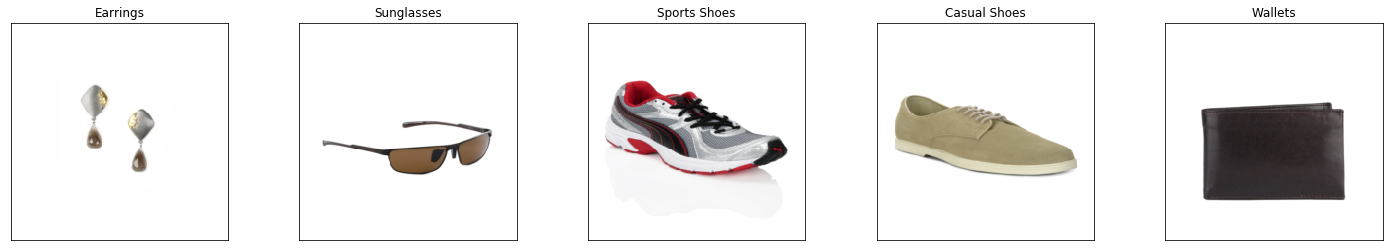

In [25]:
# Plot sample data from the training dataset of top 20 classes
plot_sample_data(train_loader, 5, num2cat)

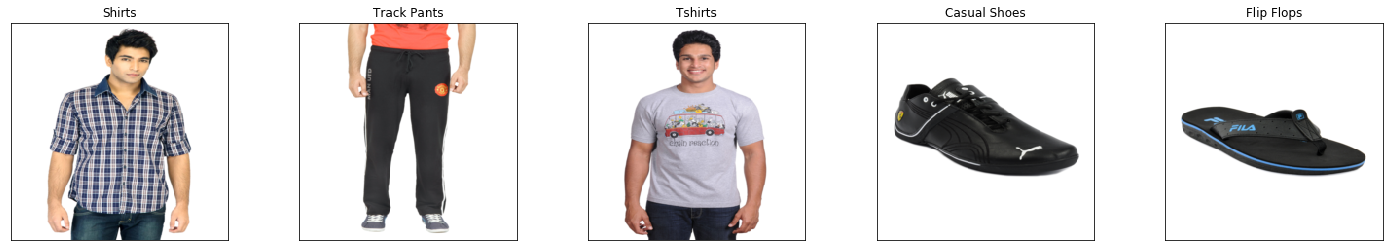

In [26]:
# Plot sample data from the training dataset of the remaining classes
plot_sample_data(test_loader, 5, num2cat)

### Find weights in order to handle the problem of imbalanced dataset
Reference: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

Class balancing techniques play an important role when we actually care about the minority classes. 
In the figure below we can see the distribution of the training data which shows us that the dataset is imbalanced.

In [34]:
# Group the df by article type and sort in descending order
sorted_df = styles.groupby(['articleType']).size().sort_values(ascending=False)

/home/ubuntu/.local/share/virtualenvs/ubuntu-7Wf190Ea/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


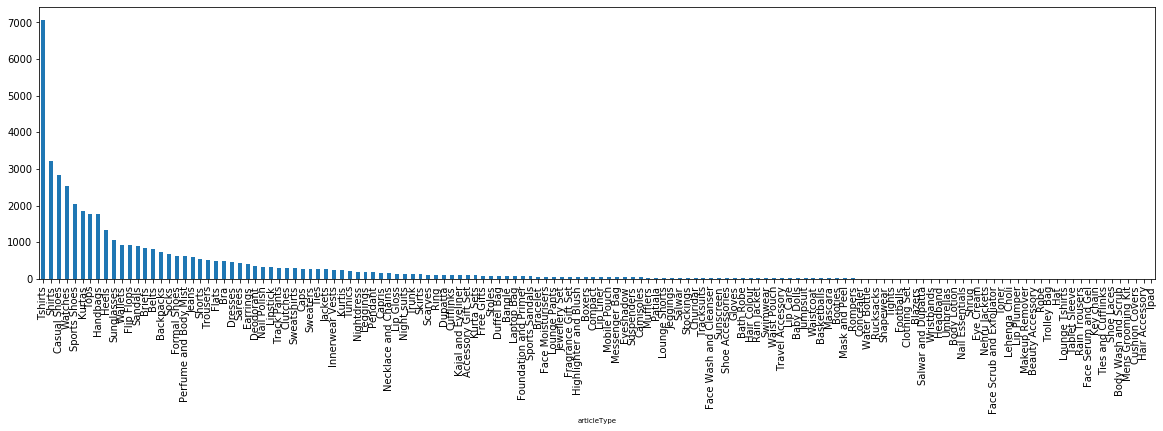

In [43]:
# plot the distribution of the whole dataset
plt.rcParams['figure.figsize'] = [20, 5]
sorted_df.plot.bar()
ax1 = plt.axes()
plt.show()

Weight balancing balances our data by altering the weight that each training example carries when computing the loss. Normally, each example and class in our loss function will carry equal weight i.e 1.0. But sometimes we might want certain classes or certain training examples to hold more weight if they are more important. That's what we do in the next step: we assign to each class i the following weight $w_i$:

\begin{equation}
w_i = \frac{total\_number\_of\_samples}{number\_of\_class\_samples}
\end{equation}

In [29]:
# Define the weights for all the 142 classes
total_number_of_samples = np.sum(sorted_df.values)
weights = [total_number_of_samples/sorted_df.values]

### Train a classifier network by initializing from a pretrained network (we choose ResNet50 trained on ImageNet) and retraining the weights of the whole network.

In [27]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Specify model architecture 
model = models.resnet50(pretrained=True)

# To reshape the network, we reinitialize the classifier’s linear layer
n_inp = model.fc.in_features
model.fc = nn.Linear(n_inp, len(cat_list))

if use_cuda:
    model = model.cuda()

In [31]:
# Convert weights vector to a tensor
weights = torch.tensor(weights,  dtype=torch.float)

if use_cuda:
    weights = weights.cuda()

# Specify a loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.SGD(model.parameters(), lr=0.001)

/home/ubuntu/.local/share/virtualenvs/ubuntu-7Wf190Ea/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [32]:
n_epochs = 20

# train the model
model, train_loss_history, valid_loss_history = train(n_epochs, train_loader, 
                                                      valid_loader, model, optimizer, 
                                                      criterion, use_cuda, 'model_direct.pt')

Epoch: 1/20 	Training Loss: 3.083353 	Validation Loss: 1.925783
Validation loss decreased (inf --> 1.925783).  Saving model ...
Epoch: 2/20 	Training Loss: 1.752158 	Validation Loss: 1.312812
Validation loss decreased (1.925783 --> 1.312812).  Saving model ...
Epoch: 3/20 	Training Loss: 1.252642 	Validation Loss: 1.040075
Validation loss decreased (1.312812 --> 1.040075).  Saving model ...
Epoch: 4/20 	Training Loss: 0.982741 	Validation Loss: 0.845438
Validation loss decreased (1.040075 --> 0.845438).  Saving model ...
Epoch: 5/20 	Training Loss: 0.809198 	Validation Loss: 0.724943
Validation loss decreased (0.845438 --> 0.724943).  Saving model ...
Epoch: 6/20 	Training Loss: 0.675220 	Validation Loss: 0.705890
Validation loss decreased (0.724943 --> 0.705890).  Saving model ...
Epoch: 7/20 	Training Loss: 0.559747 	Validation Loss: 0.675798
Validation loss decreased (0.705890 --> 0.675798).  Saving model ...
Epoch: 8/20 	Training Loss: 0.474365 	Validation Loss: 0.598951
Validation

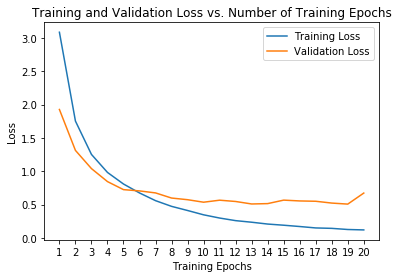

In [35]:
plot_training_and_valid_loss(train_loss_history, valid_loss_history, n_epochs)

### Testing results

In [36]:
# Load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_direct.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

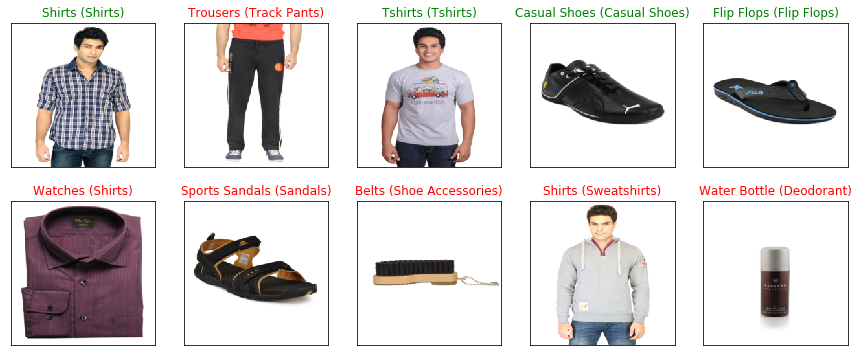

In [37]:
plot_sample_data_model(test_loader, 10, model, num2cat, use_cuda=True)

In [38]:
test(test_loader, model, criterion, cat_lookup=num2cat, use_cuda=True)

Test Loss: 4.297990

Printing 5 classes with greatest accuracy
Test Accuracy of Sunglasses: 100%
Test Accuracy of Kurta Sets: 100%
Test Accuracy of Earrings: 100%
Test Accuracy of Accessory Gift Set: 100%
Test Accuracy of Water Bottle: 100%

Printing accuracy for each class
Test Accuracy of Sunglasses: 60% (1272/2087)
Test Accuracy of Kurta Sets: 49% (133/271)
Test Accuracy of Earrings: 96% (58/60)
Test Accuracy of Accessory Gift Set:  2% ( 4/173)
Test Accuracy of Water Bottle: 90% (3897/4316)
Test Accuracy of Tights: 92% (167/181)
Test Accuracy of Footballs: 72% (942/1295)
Test Accuracy of Shapewear: 99% (318/321)
Test Accuracy of Cufflinks: 86% (352/407)
Test Accuracy of Umbrellas: 91% (692/753)
Test Accuracy of Rain Trousers: 73% (515/703)
Test Accuracy of Belts: 96% (316/329)
Test Accuracy of  Ties: 54% (230/420)
Test Accuracy of Backpacks:  0% ( 0/19)
Test Accuracy of Watches:  0% ( 0/257)
Test Accuracy of Trousers:  0% ( 0/347)
Test Accuracy of   Bra: 93% (260/278)
Test Accuracy 